In [52]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import shutil  # Necesario para mover archivos
import matplotlib.pyplot as plt


In [31]:
ruta_entrenamiento = r"C:\Users\erick\Streaming de Google Drive\Mi unidad\train-20250913T141801Z-1-001.zip"
ruta_entrenamiento_2 = r"C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset"
ruta_prueba = r"C:\Users\erick\Streaming de Google Drive\Mi unidad\perros y gatos\prueba"

#comprobar que se habre el archivo 
with zipfile.ZipFile(ruta_entrenamiento, 'r') as z:
    print("Número de archivos en ZIP:", len(z.namelist()))
    print("Primeros 10 archivos:")
    print(z.namelist()[:10])

#para mejor compatibilidad en tensorflow descomprimir archivos y crear carpetas separadas 
os.makedirs(ruta_entrenamiento_2, exist_ok=True)

with zipfile.ZipFile(ruta_entrenamiento, "r") as z:
    z.extractall(ruta_entrenamiento_2)

print("Archivos extraídos correctamente.")

Número de archivos en ZIP: 4340
Primeros 10 archivos:
['train/dog.3218.jpg', 'train/dog.4211.jpg', 'train/dog.1427.jpg', 'train/dog.4577.jpg', 'train/dog.6406.jpg', 'train/cat.6622.jpg', 'train/cat.4035.jpg', 'train/dog.429.jpg', 'train/dog.6348.jpg', 'train/cat.6144.jpg']
Archivos extraídos correctamente.


In [35]:
# estructura de prueba
gato_prueba= os.path.join(ruta_prueba, "cats")
perro_prueba= os.path.join(ruta_prueba, "dogs")

os.makedirs(gato_prueba, exist_ok=True)
os.makedirs(perro_prueba, exist_ok=True)


imagenes2 = [f for f in os.listdir(ruta_prueba) if f.endswith(".jpg")]

for  file in imagenes2:
    origen = os.path.join(ruta_prueba, file)
    if "gato" in file.lower():
        shutil.move(origen, gato_prueba)
    elif "perro" in file.lower():
        shutil.move(origen, perro_prueba)


In [36]:
# estructura de entreamiento 
entrenamiento_dir = os.path.join(ruta_entrenamiento_2, "train")
gato_entrenamiento = os.path.join(entrenamiento_dir, "cats")
perro_entrenamiento = os.path.join(entrenamiento_dir, "dogs")

os.makedirs(gato_entrenamiento, exist_ok=True)
os.makedirs(perro_entrenamiento, exist_ok=True)

def mover_si_no_existe(origen, destino_dir):
    nombre = os.path.basename(origen)
    destino = os.path.join(destino_dir, nombre)

    # Si ya existe el archivo, se salta 
    if os.path.exists(destino):
        print(f"Saltando (ya existe): {destino}")
        return

    shutil.move(origen, destino)

for subdir, _, files in os.walk(ruta_entrenamiento_2):
    if os.path.abspath(subdir).startswith(os.path.abspath(entrenamiento_dir)):
        continue 
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            origen = os.path.join(subdir,file)

            if "cat" in file.lower():
                mover_si_no_existe(origen, gato_entrenamiento)
            elif "dog" in file.lower():
                mover_si_no_existe(origen, perro_entrenamiento)




Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.3218.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.4211.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.1427.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.4577.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.6406.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.429.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.6348.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google Drive\Mi unidad\perros_gatos_dataset\train\dogs\dog.2106.jpg
Saltando (ya existe): C:\Users\erick\Streaming de Google 

In [37]:
#creacion de data sets
batch_size= 32

tamaño_imagen= (180, 180)

train_ds = keras.preprocessing.image_dataset_from_directory(
    entrenamiento_dir,
    image_size=tamaño_imagen,
    batch_size=batch_size
)

prueba_ds = keras.preprocessing.image_dataset_from_directory(
    ruta_prueba,
    image_size=tamaño_imagen,
    batch_size=batch_size
)


Found 4340 files belonging to 2 classes.
Found 119 files belonging to 4 classes.


In [ ]:
#normalizar data set

normalizar = keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalizar(x), y))
prueba_ds = train_ds.map(lambda x, y: (normalizar(x), y))

#mejorar rendimiento con autotune

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
prueba_ds = train_ds.prefetch(tf.data.AUTOTUNE)



In [46]:
#crear CNN
modelo = keras.Sequential([
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape=(180, 180,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation= 'relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')

])

C:\Users\erick\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
modelo.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [51]:
historial = modelo.fit(
    train_ds,
    validation_data=prueba_ds,
    epochs=15
)


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 581ms/step - accuracy: 0.4949 - loss: 0.6935 - val_accuracy: 0.4991 - val_loss: 0.6931
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 77s 567ms/step - accuracy: 0.4859 - loss: 0.6933 - val_accuracy: 0.5009 - val_loss: 0.6931
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 75s 555ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5009 - val_loss: 0.6931
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 84s 617ms/step - accuracy: 0.4889 - loss: 0.6933 - val_accuracy: 0.4991 - val_loss: 0.6931
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 81s 597ms/step - accuracy: 0.4949 - loss: 0.6932 - val_accuracy: 0.5009 - val_loss: 0.6931
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 77s 569ms/step - accuracy: 0.4906 - loss: 0.6932 - val_accuracy: 0.5009 - val_loss: 0.6931
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 78s 576ms/step - accuracy: 0.4915 - loss: 0.6933 - val_accuracy: 0.5009 - val_loss: 0.6931
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 583ms/step - accuracy: 0.5009 - loss: 0

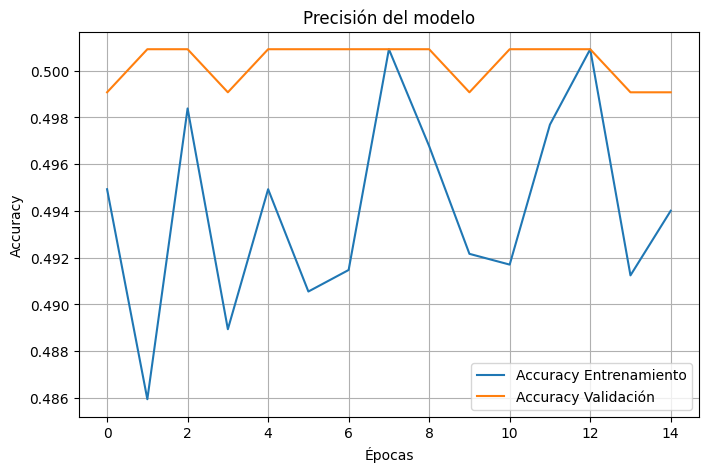

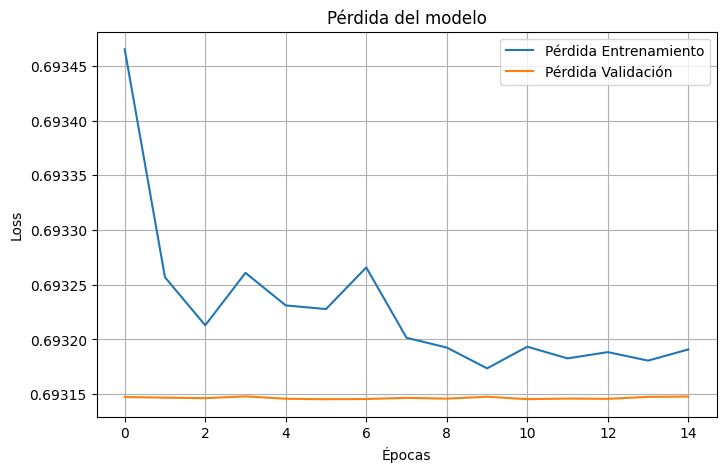

In [53]:
plt.figure(figsize=(8,5))
plt.plot(historial.history['accuracy'], label='Accuracy Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Accuracy Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Precisión del modelo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(historial.history['loss'], label='Pérdida Entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Pérdida del modelo')
plt.legend()
plt.grid(True)
plt.show()
